In [214]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

In [189]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [190]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32, 1024)
        self.fc3 = nn.Linear(1024, 10)
#        self.fc4 = nn.Linear(1024, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr,  weight_decay=l2) # weight_decay=l2
#         self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
#         x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.tanh(self.fc2(x))
#         x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
#        x = F.tanh(self.fc3(x))
#         x = F.relu(self.fc3(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [191]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
        
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
               epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
#    else:        
#        batch_idx += 1
#        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
#        epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
#        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
#        print(line + losses)

    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, train_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in train_loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                train_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
                
    for k in models:
        train_loss[k] /= train_size
    correct_pct = {k: 100. * correct[k] / train_size for k in correct}
    lines = '\n'.join([line(k, train_loss[k], correct[k], correct_pct[k]) for k in models])
    report = 'Train set:\n' + lines     
    if log is not None:
        for k in models:
            log[k].append((train_loss[k],correct_pct[k]))
    print(report)

In [192]:
models = {'default': Net(False, False),}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [193]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [194]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.331019
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.503229
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.516018
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.318373
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.400980
Train set:
default: Loss: 0.2887	Accuracy: 45771/50000 (91%)
Test set:
default: Loss: 0.2986	Accuracy: 9129/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.378315
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.273376
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.166490
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.350960
Train Epoch: 2 [40000/50000 (80%)]	Losses default: 0.309324
Train set:
default: Loss: 0.2244	Accuracy: 46754/50000 (93%)
Test set:
default: Loss: 0.2383	Accuracy: 9310/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Losses default: 0.266066
Train Epoch: 3 [10000/50000 (20%)]	Losses default: 0.132375
Train Epoch: 3 [20000/50000 (40%)]	Losses default: 0.

Train Epoch: 20 [40000/50000 (80%)]	Losses default: 0.140855
Train set:
default: Loss: 0.0482	Accuracy: 49319/50000 (98%)
Test set:
default: Loss: 0.1283	Accuracy: 9638/10000 (96%)

Train Epoch: 21 [0/50000 (0%)]	Losses default: 0.041146
Train Epoch: 21 [10000/50000 (20%)]	Losses default: 0.008605
Train Epoch: 21 [20000/50000 (40%)]	Losses default: 0.007148
Train Epoch: 21 [30000/50000 (60%)]	Losses default: 0.025971
Train Epoch: 21 [40000/50000 (80%)]	Losses default: 0.020132
Train set:
default: Loss: 0.0423	Accuracy: 49432/50000 (98%)
Test set:
default: Loss: 0.1298	Accuracy: 9633/10000 (96%)

Train Epoch: 22 [0/50000 (0%)]	Losses default: 0.005888
Train Epoch: 22 [10000/50000 (20%)]	Losses default: 0.075968
Train Epoch: 22 [20000/50000 (40%)]	Losses default: 0.005045
Train Epoch: 22 [30000/50000 (60%)]	Losses default: 0.051141
Train Epoch: 22 [40000/50000 (80%)]	Losses default: 0.072710
Train set:
default: Loss: 0.0410	Accuracy: 49431/50000 (98%)
Test set:
default: Loss: 0.1289	Accu

Train Epoch: 40 [10000/50000 (20%)]	Losses default: 0.015932
Train Epoch: 40 [20000/50000 (40%)]	Losses default: 0.002697
Train Epoch: 40 [30000/50000 (60%)]	Losses default: 0.013869
Train Epoch: 40 [40000/50000 (80%)]	Losses default: 0.019333
Train set:
default: Loss: 0.0192	Accuracy: 49705/50000 (99%)
Test set:
default: Loss: 0.1803	Accuracy: 9606/10000 (96%)

Train Epoch: 41 [0/50000 (0%)]	Losses default: 0.003149
Train Epoch: 41 [10000/50000 (20%)]	Losses default: 0.002266
Train Epoch: 41 [20000/50000 (40%)]	Losses default: 0.021864
Train Epoch: 41 [30000/50000 (60%)]	Losses default: 0.072134
Train Epoch: 41 [40000/50000 (80%)]	Losses default: 0.032174
Train set:
default: Loss: 0.0126	Accuracy: 49870/50000 (99%)
Test set:
default: Loss: 0.1772	Accuracy: 9629/10000 (96%)

Train Epoch: 42 [0/50000 (0%)]	Losses default: 0.015789
Train Epoch: 42 [10000/50000 (20%)]	Losses default: 0.007459
Train Epoch: 42 [20000/50000 (40%)]	Losses default: 0.008036
Train Epoch: 42 [30000/50000 (60%)]	

Train set:
default: Loss: 0.0045	Accuracy: 49968/50000 (99%)
Test set:
default: Loss: 0.2348	Accuracy: 9601/10000 (96%)

Train Epoch: 60 [0/50000 (0%)]	Losses default: 0.006666
Train Epoch: 60 [10000/50000 (20%)]	Losses default: 0.002593
Train Epoch: 60 [20000/50000 (40%)]	Losses default: 0.012639
Train Epoch: 60 [30000/50000 (60%)]	Losses default: 0.006263
Train Epoch: 60 [40000/50000 (80%)]	Losses default: 0.002939
Train set:
default: Loss: 0.0037	Accuracy: 49971/50000 (99%)
Test set:
default: Loss: 0.2317	Accuracy: 9603/10000 (96%)

Train Epoch: 61 [0/50000 (0%)]	Losses default: 0.004706
Train Epoch: 61 [10000/50000 (20%)]	Losses default: 0.003473
Train Epoch: 61 [20000/50000 (40%)]	Losses default: 0.002520
Train Epoch: 61 [30000/50000 (60%)]	Losses default: 0.000633
Train Epoch: 61 [40000/50000 (80%)]	Losses default: 0.008068
Train set:
default: Loss: 0.0043	Accuracy: 49972/50000 (99%)
Test set:
default: Loss: 0.2414	Accuracy: 9596/10000 (95%)

Train Epoch: 62 [0/50000 (0%)]	Losses

Train Epoch: 79 [20000/50000 (40%)]	Losses default: 0.009304
Train Epoch: 79 [30000/50000 (60%)]	Losses default: 0.000594
Train Epoch: 79 [40000/50000 (80%)]	Losses default: 0.000243
Train set:
default: Loss: 0.0011	Accuracy: 49999/50000 (99%)
Test set:
default: Loss: 0.2787	Accuracy: 9600/10000 (96%)

Train Epoch: 80 [0/50000 (0%)]	Losses default: 0.001156
Train Epoch: 80 [10000/50000 (20%)]	Losses default: 0.000333
Train Epoch: 80 [20000/50000 (40%)]	Losses default: 0.000560
Train Epoch: 80 [30000/50000 (60%)]	Losses default: 0.000359
Train Epoch: 80 [40000/50000 (80%)]	Losses default: 0.000518
Train set:
default: Loss: 0.0073	Accuracy: 49889/50000 (99%)
Test set:
default: Loss: 0.3134	Accuracy: 9550/10000 (95%)

Train Epoch: 81 [0/50000 (0%)]	Losses default: 0.008500
Train Epoch: 81 [10000/50000 (20%)]	Losses default: 0.004126
Train Epoch: 81 [20000/50000 (40%)]	Losses default: 0.001083
Train Epoch: 81 [30000/50000 (60%)]	Losses default: 0.013517
Train Epoch: 81 [40000/50000 (80%)]	

Test set:
default: Loss: 0.3101	Accuracy: 9617/10000 (96%)

Train Epoch: 99 [0/50000 (0%)]	Losses default: 0.000240
Train Epoch: 99 [10000/50000 (20%)]	Losses default: 0.000006
Train Epoch: 99 [20000/50000 (40%)]	Losses default: 0.000808
Train Epoch: 99 [30000/50000 (60%)]	Losses default: 0.019925
Train Epoch: 99 [40000/50000 (80%)]	Losses default: 0.000046
Train set:
default: Loss: 0.0024	Accuracy: 49968/50000 (99%)
Test set:
default: Loss: 0.3301	Accuracy: 9605/10000 (96%)

Train Epoch: 100 [0/50000 (0%)]	Losses default: 0.001851
Train Epoch: 100 [10000/50000 (20%)]	Losses default: 0.000299
Train Epoch: 100 [20000/50000 (40%)]	Losses default: 0.002656
Train Epoch: 100 [30000/50000 (60%)]	Losses default: 0.000764
Train Epoch: 100 [40000/50000 (80%)]	Losses default: 0.000915
Train set:
default: Loss: 0.0008	Accuracy: 49999/50000 (99%)
Test set:
default: Loss: 0.3210	Accuracy: 9614/10000 (96%)



In [250]:
import matplotlib
import matplotlib.pyplot as plt

def plot_dl(train_log, test_log, tpe='loss'):
    keys = train_log.keys()
    epochs = {k:range(len(train_log[k])) for k in keys}
    train_logs = {k:[z for z in zip(*train_log[k])] for k in keys}
    test_logs = {k:[z for z in zip(*test_log[k])] for k in keys}
    
    if tpe == 'loss':
        train_lines, = zip(*[plt.plot(epochs[k], train_logs[k][0], label=k+', train') for k in keys])
        test_lines, = zip(*[plt.plot(epochs[k], test_logs[k][0], label=k+', test') for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend([train_lines, test_lines], )
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], train_logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()


In [259]:
import matplotlib
import matplotlib.pyplot as plt

def plot_dl(train_log, test_log, tpe='loss'):
    keys = train_log.keys()
    epochs = {k:range(len(train_log[k])) for k in keys}
    train_logs = {k:[z for z in zip(*train_log[k])] for k in keys}
    test_logs = {k:[z for z in zip(*test_log[k])] for k in keys}
    
    if tpe == 'loss':
        for k in keys:
            train_lines, = zip(*[plt.plot(epochs[k], train_logs[k][0],)])
            test_lines, = zip(*[plt.plot(epochs[k], test_logs[k][0],)])
            plt.legend([train_lines, test_lines],[k+', train', k+', test'] )
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.show()
    elif tpe == 'accuracy':
        for k in keys:
            train_lines, = zip(*[plt.plot(epochs[k], train_logs[k][1],)])
            test_lines, = zip(*[plt.plot(epochs[k], test_logs[k][1],)])
            plt.legend([train_lines, test_lines],[k+', train', k+', test'] )
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()


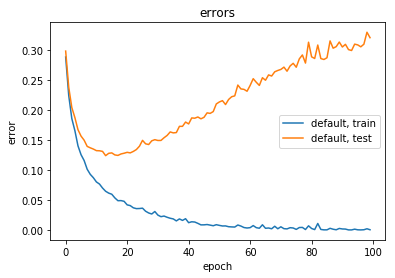

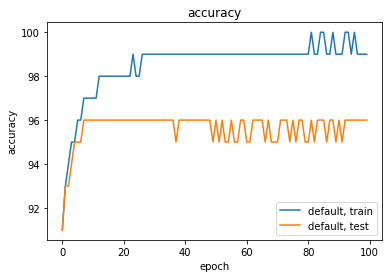

In [260]:
plot_dl(train_log, test_log, 'loss'); plot_dl(train_log, test_log, 'accuracy')
